# Simulation and decoding of a quantum error correction experiment

*Want to follow along? {nb-download}`Download this notebook.<stim_simulation.ipynb>`*

In this notebook, we simulate a quantum error correction experiment and demonstrate all the steps required to decode the data produced. In particular, we:

* generate a circuit for a repetition code quantum memory experiment;
* generate the same circuit compiled to a particular set of native gates;
* add noise to the circuit;
* simulate the noisy circuit to obtain measurement results;
* decode the measurement results;
* combine the above steps to perform multiple quantum memory experiments and explore the results.

## A short introduction to decoding 

When performing error correction, we use multiple physical qubits to represent a single logical qubit, thereby introducing redundancy into the system. In order to understand what errors have occurred on the physical qubits, and how they might have affected our logical qubit state, we make measurements across combinations of physical qubits. These combinations are known as detectors. In the absence of errors, each detector should have a deterministic value. These detectors can therefore be used to learn about the errors that have occurred. This process is known as decoding, and is the job of a decoder. 

In general, solving the decoding problem optimally is very computationally intensive and thus decoders typically involve some level of approximation. Different decoders approach the problem differently, and may perform more or less well depending on the particular decoding problem. Even an optimal decoder will not be correct every time, as multiple different combinations of errors can lead to the same detector values. This is a problem if the different error combinations have different effects on the logical qubit. For example, a particular combination of errors may have caused a logical **X** error (flipping the logical `|0⟩` component to the logical `|1⟩` component and vice versa), but the decoder may decide a different combination of errors, which does not cause a logical **X** error but result in the same detector outcomes, instead occurred. This is a logical error. 

In order for us to know with certainty that a logical error occurred, we need to know the intended state of the logical qubit. For example, if a logical qubit is measured to be in the `|1⟩` state but intended to be in the `|0⟩` state, we know that a logical **X** error occurred. Conversely, if we don’t know the intended state of the logical qubit then we cannot know whether a logical error occurred. This makes finding out whether or not a logical error occurred in a large fault-tolerant quantum computation challenging unless we have a way of verifying the output. However, in small experiments, such as those considered here, we typically know what the true logical state should be, and thus are able to determine whether a logical error has occurred. 

**In this notebook, we will be estimating logical error probabilities – that is, probabilities of logical errors occurring.** These are found by performing or simulating an experiment multiple times and calculating the proportion of the time a logical error occurred. The logical error probability depends on the properties of the quantum computer, the particular experiment that is run, and the decoder. The logical error probabilities in this notebook are calculated using data from simulated quantum error correction experiments.

## Preparation
### Perform all necessary imports

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import stim
from deltakit.explorer import Client
from deltakit.explorer.enums import DecoderType
from deltakit.explorer.types import (
    CircuitParameters,
    Decoder,
    PhysicalNoiseModel,
    QECExperimentDefinition,
    Sizes,
)

client = Client.get_instance()

## Generate an experiment circuit

The code below generates a circuit for a quantum memory experiment using the repetition code. The repetition code can only protect qubits against one type of error and thus is not suitable for large-scale error-corrected calculations; however, it provides useful insight into the performance of error correction experiments. First, we will generate a circuit with a default textbook gate set. This circuit is for a one-round quantum memory experiment with the distance-3 repetition code, seeking to preserve the logical `|0⟩` state. The distance specifies the smallest number of errors needed so that we have an undetectable logical error -- an error that destroys the state of the logical qubit without us knowing -- and depends on the number of qubits we use.

In [2]:
experiment_definition = QECExperimentDefinition.get_repetition_z_quantum_memory(
    distance=3,
    num_rounds=1,
)

textbook_circuit = client.generate_circuit(experiment_definition)

We can display the circuit. Each horizontal line corresponds to a qubit. The first column of boxes give the coordinate labels of the qubits. These are not necessary to simulate a circuit, but are useful to understand which qubit is which. The second column of boxes correspond to reset gates. The circles connected by lines are two-qubit controlled-Z gates. The final operations on the qubits are measurements. These measurements are then used to calculate the detector values -- which measurements are combined to form which detectors are indicated by the "rec" labels. The measurements are also used to calculate the observed value of logical measurement, indicated by "OBS_INCLUDE". By decoding, we perform error correction on this logical measurement.

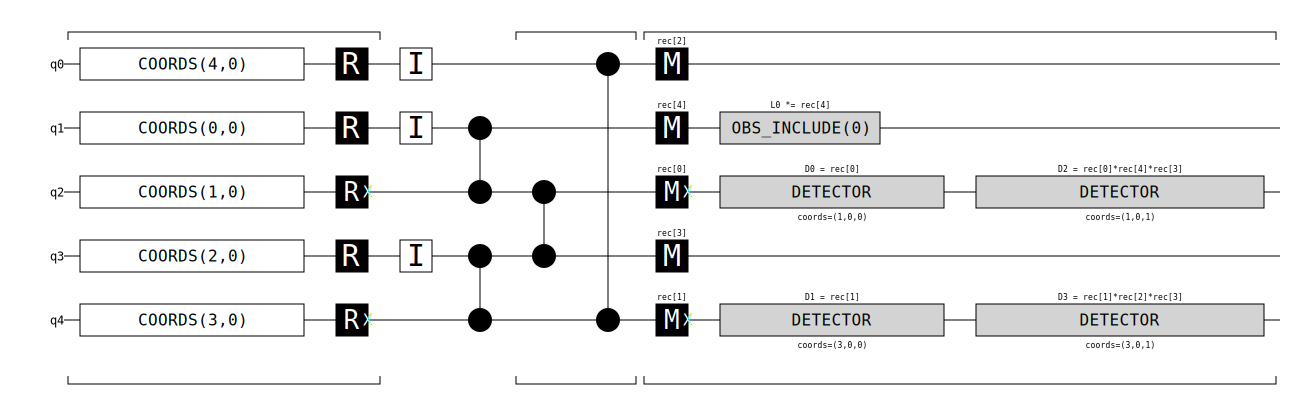

In [3]:
circuit = stim.Circuit(textbook_circuit)
circuit.diagram(type="timeline-svg")

We now generate a circuit for the same quantum error correction experiment but in terms of a specific native gate set. In particular, the circuit above includes qubit reset and measurement in the **X**-basis. In general, quantum computers can only reset and measure qubits in the **Z**-basis. We specify this through the "RZ" and "MZ" elements below. Before returning the circuits below, the **X**-basis resets and measurements are compiled.

In [4]:
experiment_definition.basis_gates = ["CZ", "H", "MZ", "RZ"]

compiled_circuit = client.generate_circuit(experiment_definition)

We now display the experiment circuit again, this time compiled to the specific native gate set. We see that the **X**-basis resets and measurements have been replaced with **Z**-basis resets and measurements along with Hadamard gates to change the basis. We note the Hadamard gates at the end of the circuit are used to restore the basis; however, as they occur after the final measurements in the circuit, they have no effect.

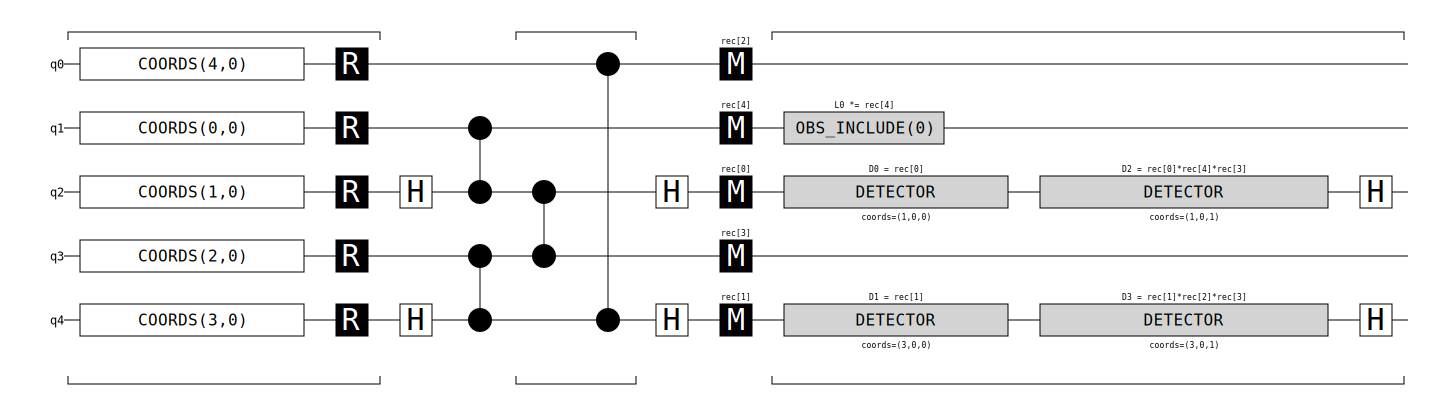

In [5]:
stim.Circuit(compiled_circuit).diagram(type="timeline-svg")

(client-add-noise-to-the-circuit)=

## Add noise to the circuit
In order to perform a simulation of a quantum error correction experiment, we wish to make the circuit noisy, so that errors occur. We specify the noise parameters we wish to use for the simulation, including characteristic times of the device and its operations and the probability of errors occurring during different operations. We then take the circuit generated above, add errors to it and save the resulting noisy circuit.

This noise model will also be passed to the decoder. The decoder uses it in order to work out the most likely combination of errors that can explain the observed detector outcomes.

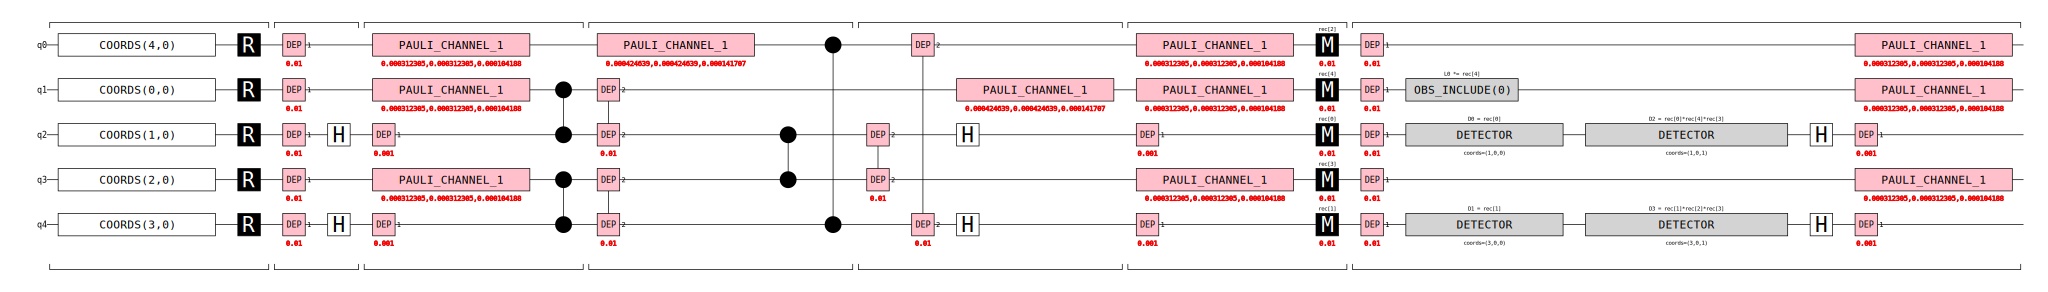

In [6]:
noise_model = PhysicalNoiseModel.get_superconducting_noise()

noisy_circuit = client.add_noise(
    stim_circuit=compiled_circuit,
    noise_model=noise_model,
)

stim.Circuit(noisy_circuit).diagram(type="timeline-svg")

## Simulate and decode an error correction experiment

In this section, we simulate running a single experiment, with a fixed number of error correction rounds and decode the data produced. We will perform the simulation with Stim. We note that simulation with Stim is usually quite fast, so for a small circuit you will obtain millions of shots (circuit repetitions) in seconds. However, decoding these results may take orders of magnitude more time. We therefore recommend starting with small numbers of shots, e.g., `10_000`.

### Run simulation

We simulate the noisy experiment circuit generated above and save the measurement outcomes to file.

In [7]:
num_shots = 100_000

measurements, _ = client.simulate_stim_circuit(
    stim_circuit=noisy_circuit,
    shots=num_shots,
)

### Decode

We now decode the measurement outcomes in order to find the error-corrected value of the logical measurement for each shot. We record the number of times the decoder failed to determine the value of the logical measurement correctly. From this, and the total number of shots, we estimate the probability of a logical error occurring.

In [8]:
decoder = Decoder(DecoderType.MWPM)

decode_result = client.decode_measurements(
    measurements=measurements,
    decoder=decoder,
    ideal_stim_circuit=compiled_circuit,
    noise_model=noise_model,
)

## Generate, simulate and decode multiple error correction experiments

In larger error correction experiments, it is often necessary to perform multiple rounds of error correction to get good performance. As a result, it is useful to explore the performance of quantum memory experiments as the number of rounds varies. We will now generate, simulate and decode multiple quantum memory experiments with increasing numbers of rounds.

We first generate the compiled, error-free circuits, using the same gates as above. We generate circuits for distance-3 repetition code quantum memory experiments, with numbers of rounds equal to 1, 3, 5 and 7.

In [9]:
compiled_circuits = {}
all_rounds = [1, 3, 5, 7]

for num_rounds in all_rounds:
    # reuse the experiment definition object
    experiment_definition.num_rounds = num_rounds
    compiled_circuits[num_rounds] = client.generate_circuit(experiment_definition)

Next, we add noise to these circuits, using the noise model we defined above.

In [10]:
noisy_circuits = {}
for num_rounds, circuit in compiled_circuits.items():
    noisy_circuits[num_rounds] = client.add_noise(
        stim_circuit=circuit,
        noise_model=noise_model,
    )

Now, for each experiment, we simulate the circuit to obtain measurements and then perform decoding. Using the results, we calculate the logical failure probabilities.

In [11]:
num_shots = 100_000
results = {}

for num_rounds in all_rounds:
    compiled_circuit = compiled_circuits[num_rounds]
    noisy_circuit = noisy_circuits[num_rounds]

    measurements, _ = client.simulate_stim_circuit(
        stim_circuit=noisy_circuit,
        shots=num_shots,
    )

    decode_result = client.decode_measurements(
        measurements=measurements,
        decoder=decoder,
        ideal_stim_circuit=compiled_circuit,
        noise_model=noise_model,
    )
    results[num_rounds] = decode_result


We can plot the results, with the number of rounds of error correction on the x-axis and the logical error probability on the y-axis.

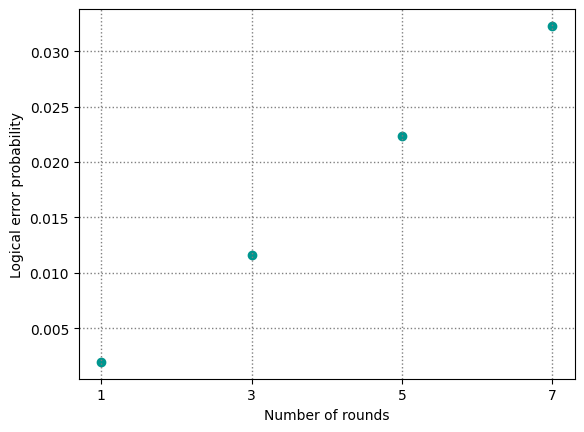

In [12]:
logical_error_probs_d3 = [results[num_rounds].get_logical_error_probability() for num_rounds in all_rounds]
plt.scatter(all_rounds, logical_error_probs_d3, color="#00968f")

plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xticks(all_rounds)
plt.xlabel("Number of rounds")
plt.ylabel("Logical error probability")
plt.show()

Through this, we can see the effect of increasing the number of rounds in a distance-3 repetition code quantum memory experiment. We see that the logical error probability increases with the number of rounds. Therefore, if we wish to decrease the logical error probability, we must do something else. We will explore that in the next section.

## Explore the effect of increasing the distance

In this section, we will again generate, simulate and decode multiple error correction experiments. We will generate the same circuits as those above but for a distance-5 repetition code. These are able to correct more errors and thus will decrease the logical error probability at a fixed number of rounds.

In [13]:
logical_error_probs_d5 = []
experiment_definition.parameters = CircuitParameters(sizes=Sizes([5]))
for num_rounds in all_rounds:
    experiment_definition.num_rounds = num_rounds
    compiled_circuit = client.generate_circuit(experiment_definition)

    noisy_circuit = client.add_noise(
        stim_circuit=compiled_circuit,
        noise_model=noise_model
    )

    measurements, _ = client.simulate_stim_circuit(
        stim_circuit=noisy_circuit,
        shots=num_shots,
    )

    decode_result = client.decode_measurements(
        measurements=measurements,
        decoder=decoder,
        ideal_stim_circuit=compiled_circuit,
        noise_model=noise_model,
    )
    logical_error_probs_d5.append(decode_result.get_logical_error_probability())


Now we plot the results along with our distance-3 results obtained above.

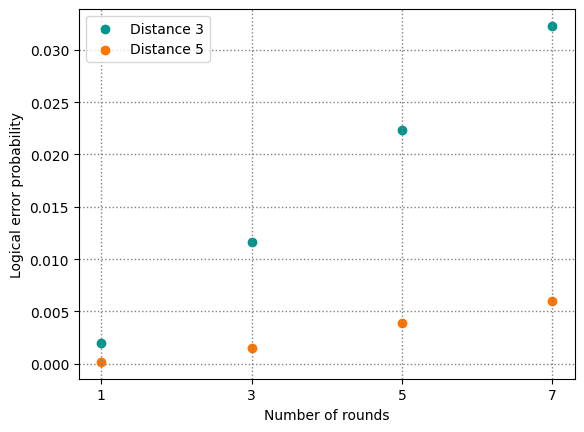

In [14]:
plt.scatter(all_rounds, logical_error_probs_d3, color="#00968f", label="Distance 3")
plt.scatter(all_rounds, logical_error_probs_d5, color="#ff7500", label="Distance 5")

plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xticks(all_rounds)
plt.xlabel("Number of rounds")
plt.ylabel("Logical error probability")
plt.legend()
plt.show()

We see how increasing the distance of the code decreases the logical error probability. If we were to increase the distance again, we would expect to see further error suppression.

## Summary
In this notebook, we have seen how to generate, simulate and decode error correction experiments. In particular, we have explored quantum memory experiments using the repetition code. We have seen how the logical error probability increases with increasing number of rounds and decreases with increasing distance.